In [1]:
import requests
import pandas as pd
import numpy as np 
from pyarrow import fs
import pyarrow as pa
import pyarrow.parquet as pq
from scipy.stats import zscore
import matplotlib.pyplot as plt
from tqdm import tqdm
pd.set_option('display.float_format', '{:.2f}'.format)


In [2]:
def get_names_geo_data_from_sncf_api(endpoint_suffix, **kwargs):
    base_url = "https://ressources.data.sncf.com"
    # Endpoint for the desired dataset
    endpoint = f"/api/explore/v2.1/catalog/datasets/{endpoint_suffix}/records"
    # Parameters for the API request
    params = {
        "limit": 100,  # in this API maximum limit is 100
        "offset": 0,  # we start from 0 to 100, then FROM 100 to 200 etc etc, but limit is fixed at 100, it is moving
    }
    params.update(kwargs)
    # Construct the full URL
    url = f"{base_url}{endpoint}"
    response = requests.get(url, params=params)
    wb = response.json()
    resulting_dictionnary = wb["results"].copy()
    while wb["results"] != []:
        params["offset"] = params["offset"] + 100
        response = requests.get(url, params=params)
        if response.status_code == 200:
            wb = response.json()
            for element in wb["results"]:
                resulting_dictionnary.append(element)
    # verify nb of observations
    print(
        f"nb of stations downloaded: {len(resulting_dictionnary)}, from table {endpoint_suffix}"
    )
    df = pd.json_normalize(resulting_dictionnary)
    return df


def get_absent_lat_lon_from_gouv_api(df):
    empties = df[df["lon_gare"].isna()].copy()
    base_url = "https://api-adresse.data.gouv.fr/search/"
    # Paramètres de la requête
    params = {"q": "", "limit": 1}
    i = 0
    for idx, row in empties.iterrows():
        params["q"] = "gare de " + row["nom_gare"]
        response = requests.get(base_url, params=params)
        try:
            data = response.json()
            coordinates = data["features"][0]["geometry"]["coordinates"]
            i = i + 1
        except:
            coordinates = [None, None]
        df.loc[idx, "lon_gare"] = coordinates[0]
        df.loc[idx, "lat_gare"] = coordinates[1]
    print(i, "absent addresses filled successfully")
    return df

def fill_regional_stat_with_lat_lon(regional_stat):

  base_url = "https://api-adresse.data.gouv.fr/search/"
  # Paramètres de la requête
  params = {"q": "", "limit": 1}
  i = 0
  for idx, row in tqdm(regional_stat.iterrows(), desc="Processing"):
   
     params["q"] = f"{row["nomcommune"]} {row["codecommune"]}"
     response = requests.get(base_url, params=params)
     try :
         data = response.json()
         coordinates = data["features"][0]["geometry"]["coordinates"]
         i = i + 1
     except:
         coordinates = [None, None]
     regional_stat.loc[idx, "lon"] = coordinates[0]
     regional_stat.loc[idx, "lat"] = coordinates[1]
  return regional_stat

def delete_outliers_z_score(df, series):
    df["z_score"] = zscore(series)
    no_outliers_table = df[df["z_score"].abs() < 3]

    print("nb removed observations : ", df.shape[0] - no_outliers_table.shape[0])
    no_outliers_table = no_outliers_table.drop("z_score", axis=1)
    return no_outliers_table


def plot_hist(series, title_suffix=""):

    plt.figure(figsize=(3, 2))
    plt.hist(series, bins=50, edgecolor="black")
    plt.title(f"Histogram of {series.name} {title_suffix}", fontsize=14)
    plt.xlabel(series.name, fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.grid(axis="y", linestyle="--")
    plt.show()


def simple_plot_map():
    plt.scatter(merged["lon"], merged["lat"], s=1, color="black")
    plt.title("Stations in France")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()


class s3_connection():
    def __init__(self,directory):
        try:
         s3 = fs.S3FileSystem(endpoint_override="https://" + "minio.lab.sspcloud.fr")
         s3.get_file_info(fs.FileSelector(directory, recursive=True))
         print("connection successful")
        except:
         s3="connection not established, debug "
         print(s3)
        self.s3=s3
     
    def from_json_to_parquet_store_in_s3(self,json_table, directory):
      table = pa.Table.from_pylist(json_table)
      pq.write_table(table, directory, filesystem=self.s3)
  
    def from_pandas_to_parquet_store_in_s3(self,df, directory):
      table = pa.Table.from_pandas(df)
      pq.write_table(table, directory, filesystem=self.s3)
   
    def get_tables_from_s3(self,directory):
        df = pq.ParquetDataset(directory, filesystem=self.s3).read_pandas().to_pandas()
        return df
    

def haversine_vectorized(lat1, lon1, lat2, lon2):
    """ 
    
    References
    ---------

    https://www.movable-type.co.uk/scripts/latlong.html
    https://www.igismap.com/haversine-formula-calculate-geographic-distance-earth/
    """
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])
    # Haversine formula from ressources
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.atan2(np.sqrt(a), np.sqrt((1-a)))
    r = 6371  # Radius of Earth in kilometers
    return c * r #dist in km 

 extract tables from api

In [3]:
station_geo_data = get_names_geo_data_from_sncf_api(
    endpoint_suffix="gares-de-voyageurs",
    select="""nom as nom_gare,
                           position_geographique,
                           codes_uic as uic""",
)

station_freq_data = get_names_geo_data_from_sncf_api(
    endpoint_suffix="frequentation-gares",
    select="""total_voyageurs_2022,
                           code_postal,
                           nom_gare,
                           code_uic_complet as uic """,
)

nb of stations downloaded: 2881, from table gares-de-voyageurs
nb of stations downloaded: 3010, from table frequentation-gares


In [4]:
s3=s3_connection("aayrapetyan")

connection successful


connect to s3, store tables from api to s3

extract tables from s3

In [5]:
station_geo_data=station_geo_data.rename(columns={'position_geographique.lon': 'lon_gare', 'position_geographique.lat': 'lat_gare'})
station_geo_data=station_geo_data.drop("position_geographique",axis=1)

In [6]:
merged=station_freq_data.merge(station_geo_data.drop("nom_gare",axis=1),on=["uic"],how="left")
merged=merged[merged["total_voyageurs_2022"]>0]


In [7]:
merged=get_absent_lat_lon_from_gouv_api(merged)
merged.isna().sum()

94 absent addresses filled successfully


total_voyageurs_2022    0
code_postal             0
nom_gare                0
uic                     0
lon_gare                0
lat_gare                0
dtype: int64

get stat about regions

In [8]:

regional_stat=s3.get_tables_from_s3("clichere/diffusion/rev_dip_pop_comm.parquet")

In [9]:
regional_stat=regional_stat[(regional_stat["pop2022"]>0) & (regional_stat["revmoy2022"]>0) & (regional_stat["pbac2022"].notna())   ]

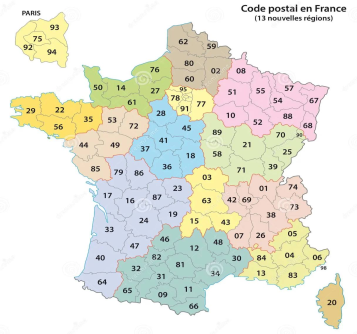
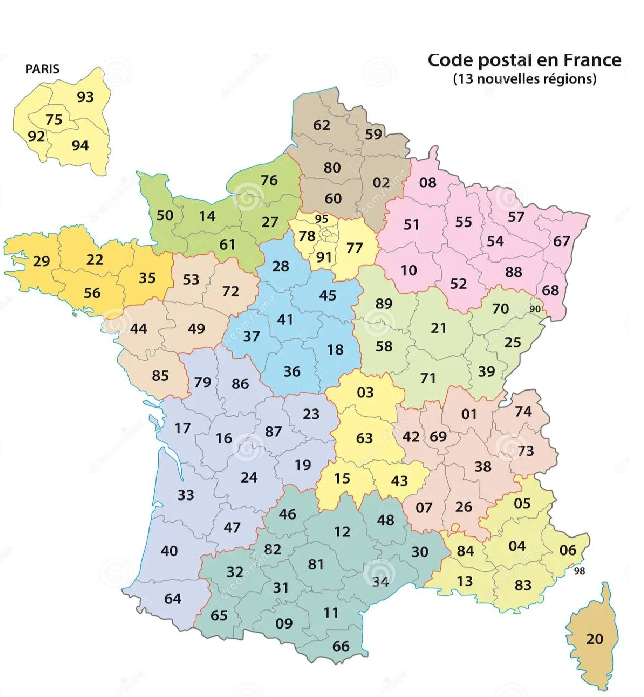
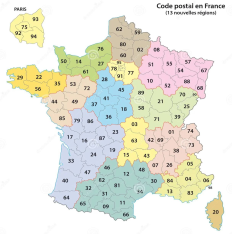
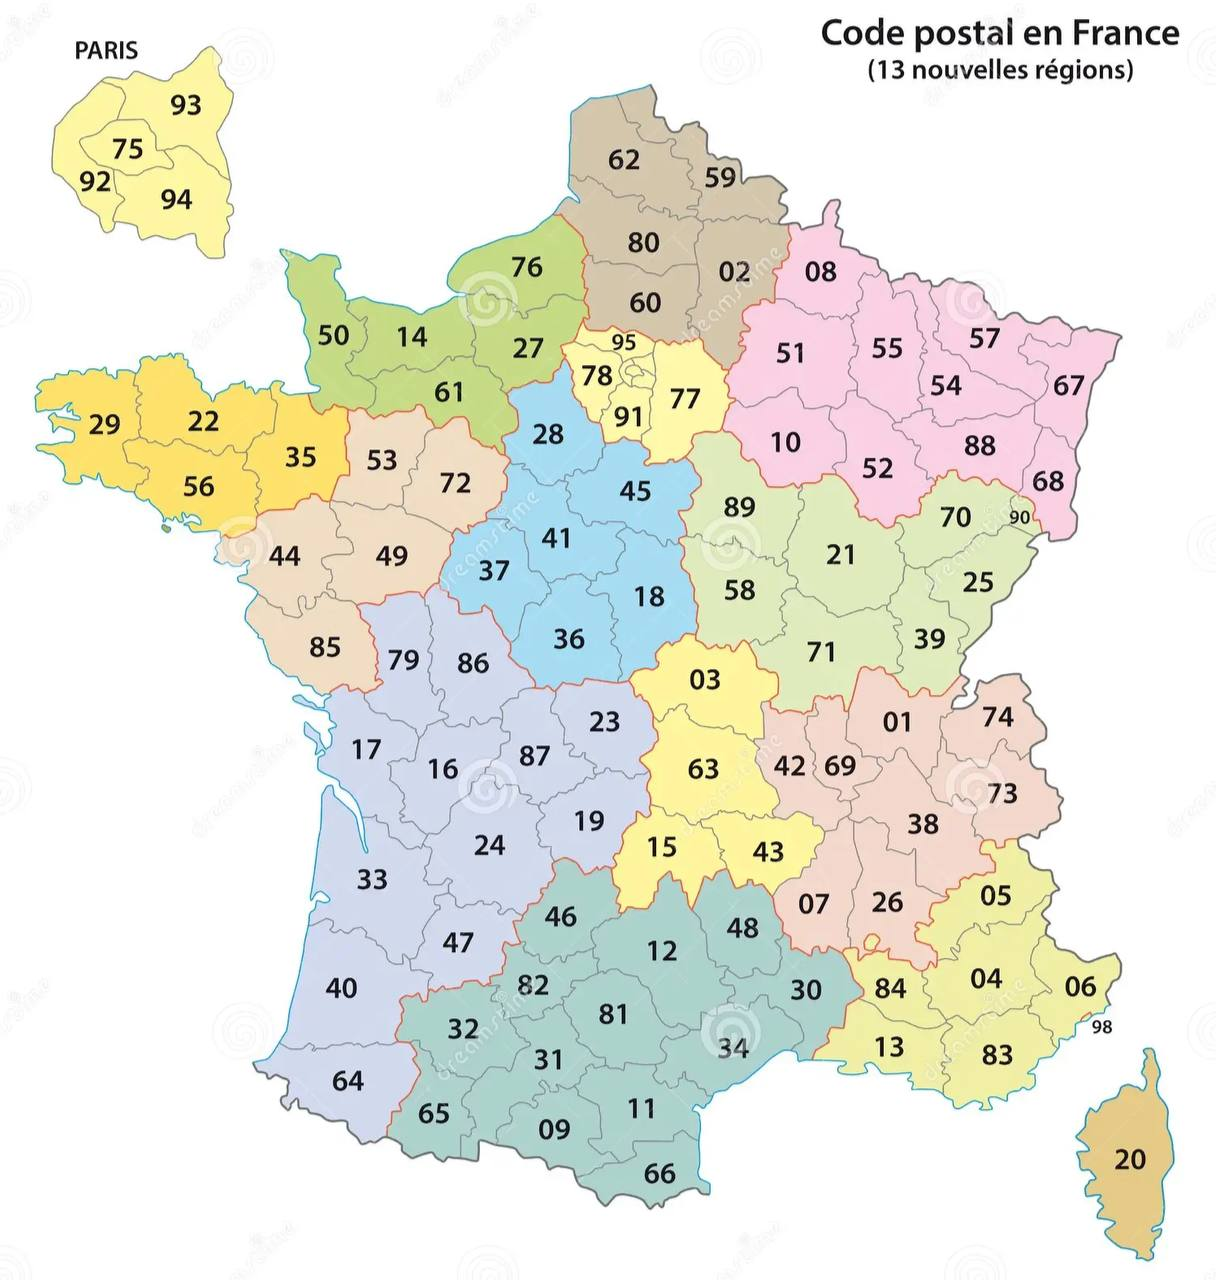

In [10]:
regional_stat=fill_regional_stat_with_lat_lon(regional_stat)

Processing: 34711it [37:30, 15.42it/s]


In [11]:
regional_stat.sample(2)

,codecommune,nomcommune,pop2022,revmoy2022,pbac2022,psup2022,lon,lat
17090,44106,MOUTIERS-EN-RETZ,1868,21421.68,0.40,0.21,-2.00,47.06
638,02224,COURCELLES-SUR-VESLE,370,13772.33,0.00,0.00,3.57,49.34


In [12]:
fusion=merged.merge(regional_stat,left_on="code_postal",right_on="codecommune",how="left")

In [13]:
fusion.sample(2)

,total_voyageurs_2022,code_postal,nom_gare,uic,lon_gare,lat_gare,codecommune,nomcommune,pop2022,revmoy2022,pbac2022,psup2022,lon,lat
1007,110387,80133,Noyelles-sur-Mer,87317396,1.70,50.19,80133,BRAILLY-CORNEHOTTE,285.00,12382.98,0.37,0.06,1.96,50.22
2494,422514,91520,Égly,87545475,2.22,48.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
fusion.isna().sum()

total_voyageurs_2022       0
code_postal                0
nom_gare                   0
uic                        0
lon_gare                   0
lat_gare                   0
codecommune             1482
nomcommune              1482
pop2022                 1482
revmoy2022              1482
pbac2022                1482
psup2022                1482
lon                     1484
lat                     1484
dtype: int64

In [15]:
no_math=fusion[fusion["codecommune"].isna()]
yes_math=fusion[fusion["codecommune"].notna()]

In [16]:
crossed=no_math[["uic","lon_gare","lat_gare"]].merge(regional_stat[["codecommune","nomcommune","lon","lat"]],how="cross")

In [17]:
crossed.sample(2)

,uic,lon_gare,lat_gare,codecommune,nomcommune,lon,lat
25509131,87765826,4.92,44.01,80397,GUEUDECOURT,2.84,50.06
33942009,87592105,1.65,45.76,76225,ECRETTEVILLE-LES-BAONS,0.67,49.63


In [18]:

crossed["distance_km"] = haversine_vectorized(crossed["lat_gare"], crossed["lon_gare"], crossed["lat"], crossed["lon"])




In [19]:
idx = crossed.groupby(['uic'])['distance_km'].idxmin()

# Select rows corresponding to the minimal distances
result = crossed.loc[idx].reset_index(drop=True)

In [20]:
no_math_filled=result.merge(merged[["total_voyageurs_2022","code_postal","nom_gare","uic"]],on=["uic"],how="left").merge(regional_stat[["codecommune"	,	"pop2022",	"revmoy2022",	"pbac2022",	"psup2022"]],on=["codecommune"],how="left")

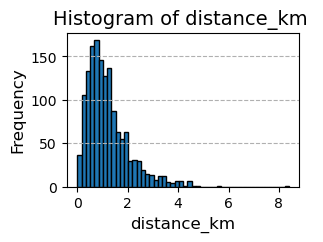

In [21]:
plot_hist((no_math_filled["distance_km"]))

In [22]:
no_math_filled=no_math_filled.drop("distance_km",axis=1)

In [23]:
yes_math=yes_math.reset_index(drop=True)

In [25]:
final=pd.concat([yes_math,no_math_filled[yes_math.columns]],axis=0)

In [32]:
final=final[final["lon"].notna()].drop(["lon","lat"],axis=1)


In [33]:
final.shape

(2938, 12)

In [34]:
final

,total_voyageurs_2022,code_postal,nom_gare,uic,lon_gare,lat_gare,codecommune,nomcommune,pop2022,revmoy2022,pbac2022,psup2022
0,40825,44170,Abbaretz,87481614,-1.52,47.55,44170,ST-JULIEN-DE-VOUVANTES,1017.00,12806.55,0.32,0.16
1,80648,62121,Achiet-le-Grand,87342048,2.78,50.13,62121,BEUGNATRE,243.00,8432.39,0.53,0.13
2,11325,30220,Aigues-Mortes,87775858,4.19,43.57,30220,ROQUEDUR,312.00,7633.23,0.67,0.42
3,128969,80250,Ailly-sur-Noye,87313221,2.36,49.75,80250,DOMVAST,365.00,14541.22,0.54,0.38
4,126465,73210,Aime - La Plagne,87741769,6.65,45.55,73210,PUYGROS,417.00,17936.02,0.61,0.47
...,...,...,...,...,...,...,...,...,...,...,...,...
1477,122,66760,Ur - Les Escaldes,87784884,1.94,42.46,66218,UR,311.00,18354.76,0.34,0.34
1478,86,66760,Bena Fanes,87784892,1.92,42.46,66066,ENVEITG,663.00,14575.08,0.49,0.46
1479,71860,66290,Cerbère,87785006,3.16,42.44,66048,CERBERE,1266.00,14498.83,0.36,0.16
1480,623710,93140,Remise à Jorelle,87988709,2.49,48.89,93010,BONDY,53353.00,12882.64,0.43,0.24


In [35]:
s3.from_pandas_to_parquet_store_in_s3(final,"aayrapetyan/final_table.parquet")

In [36]:
s3.get_tables_from_s3("aayrapetyan/final_table.parquet")

,total_voyageurs_2022,code_postal,nom_gare,uic,lon_gare,lat_gare,codecommune,nomcommune,pop2022,revmoy2022,pbac2022,psup2022
0,40825,44170,Abbaretz,87481614,-1.52,47.55,44170,ST-JULIEN-DE-VOUVANTES,1017.00,12806.55,0.32,0.16
1,80648,62121,Achiet-le-Grand,87342048,2.78,50.13,62121,BEUGNATRE,243.00,8432.39,0.53,0.13
2,11325,30220,Aigues-Mortes,87775858,4.19,43.57,30220,ROQUEDUR,312.00,7633.23,0.67,0.42
3,128969,80250,Ailly-sur-Noye,87313221,2.36,49.75,80250,DOMVAST,365.00,14541.22,0.54,0.38
4,126465,73210,Aime - La Plagne,87741769,6.65,45.55,73210,PUYGROS,417.00,17936.02,0.61,0.47
...,...,...,...,...,...,...,...,...,...,...,...,...
1477,122,66760,Ur - Les Escaldes,87784884,1.94,42.46,66218,UR,311.00,18354.76,0.34,0.34
1478,86,66760,Bena Fanes,87784892,1.92,42.46,66066,ENVEITG,663.00,14575.08,0.49,0.46
1479,71860,66290,Cerbère,87785006,3.16,42.44,66048,CERBERE,1266.00,14498.83,0.36,0.16
1480,623710,93140,Remise à Jorelle,87988709,2.49,48.89,93010,BONDY,53353.00,12882.64,0.43,0.24


# visuqlisations

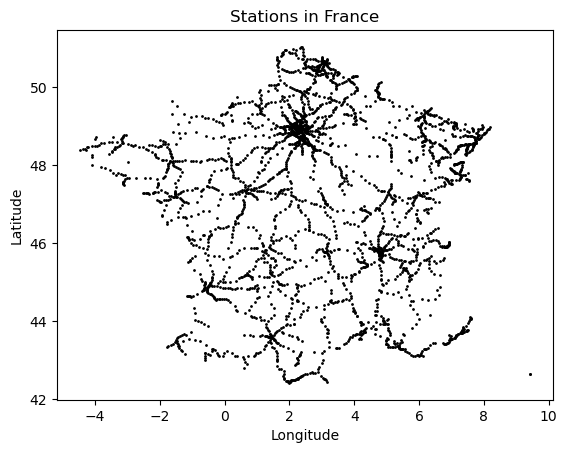

In [46]:
simple_plot_map()

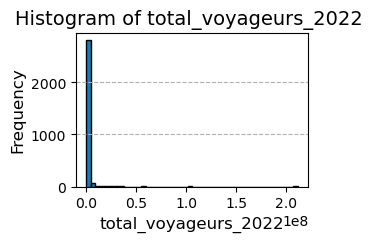

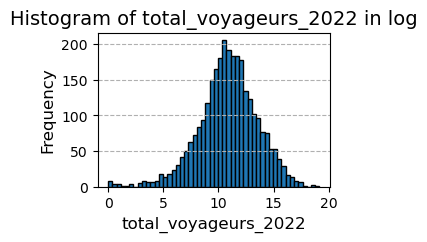

nb removed observations :  24


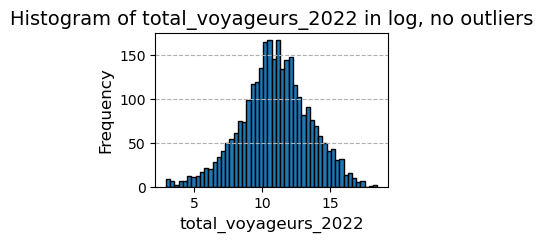

In [106]:
plot_hist(series=(merged['total_voyageurs_2022']))
plot_hist(series=np.log(merged['total_voyageurs_2022']),title_suffix="in log")
no_outliers_table=delete_outliers_z_score(merged,np.log(merged["total_voyageurs_2022"]))
plot_hist(np.log(no_outliers_table['total_voyageurs_2022']),title_suffix="in log, no outliers")


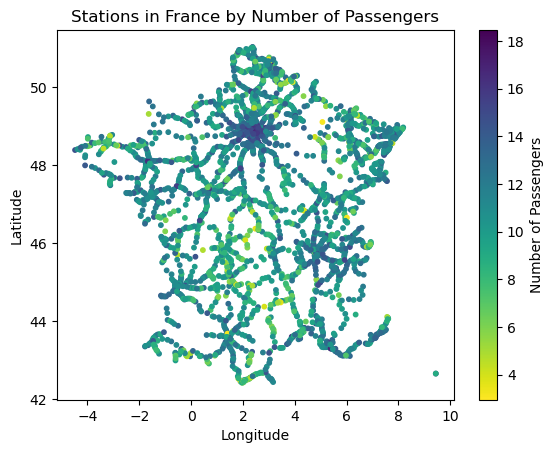

In [ ]:

plt.scatter(
    no_outliers_table['lon'], 
    no_outliers_table['lat'], 
    s=10,  # Increase size for visibility
    c=np.log(no_outliers_table['total_voyageurs_2022']),  # Color based on number of passengers
    cmap='viridis_r'  # Use a perceptible color map
)
plt.colorbar(label='Number of Passengers')  # Add color legend
plt.title("Stations in France by Number of Passengers")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()
#idea about difference in france among regions but... size effect because of population disperancy, so we have to take population info too to adjust for it 

In [107]:
no_outliers_table

,total_voyageurs_2022,code_postal,nom_gare,uic,codeinsee,lon,lat
0,40825,44170,Abbaretz,87481614,44001,-1.52,47.55
1,177092,78100,Achères Grand Cormier,87386052,78551,2.09,48.96
2,80648,62121,Achiet-le-Grand,87342048,62005,2.78,50.13
3,32800,83530,Agay,87757559,83118,6.86,43.43
4,11325,30220,Aigues-Mortes,87775858,30003,4.19,43.57
...,...,...,...,...,...,...,...
3004,176599,67720,Weyersheim,87213678,67529,7.80,48.72
3005,30849,68760,Willer-sur-Thur,87182584,68372,7.07,47.84
3006,37020,62126,Wimille - Wimereux,87317123,62894,1.61,50.76
3007,38618,40100,Ygos-Saint-Saturnin,87671487,40333,-0.74,43.98


In [ ]:
# import folium
# import requests


# geojson_url = "https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/departements-version-simplifiee.geojson"
# geojson_data = requests.get(geojson_url).json()
# #Create a base map centered on France
# france_map = folium.Map(location=[46.603354, 1.888334], zoom_start=6)
# #SON layer to the map with style
# folium.GeoJson(
#     geojson_data,
#     name="Departments",
#     style_function=lambda x: {
#         'fillColor': '#ff7800',  # Use distinct colors or randomization for better visibility
#         'color': 'black',
#         'weight': 1,
#         'fillOpacity': 0.5
#     },
#     tooltip=folium.GeoJsonTooltip(fields=["nom"], aliases=["Department"])  # Tooltip to show department name
# ).add_to(france_map)
# folium.LayerControl().add_to(france_map)


